# Cuckoo output JSON(API) タイムライン可視化分析

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

ファイルパスとプロセスを指定

In [2]:
FILEPATH = 'test.json'
PROC_IDX = 1 # index of processes in behavior

In [3]:
f = open(FILEPATH)
r = f.read()
j_str = json.loads(r)
rd = j_str['behavior']['processes'][PROC_IDX]['calls']

パラメータ変更時はここから実行

In [4]:
BIN = 0.2 # API aggregation span
TIMERANGE = (0, 5) # API filter span[s]: process start time = 0
APIFILTER = [] # api filter. [] means no filter. example: ['IsDebuggerPresent', 'ShellExecuteExW',]
MODE = ('all','file','reg') # mode. [all, proc, file, reg]. multiple select.
# all -- display all api (but not below additional info)
# proc -- display LdrGetProcedureAddress args (function_name)
# file -- display NtCreateFile etc args (filepath_r)
# reg -- display NtQueryValueKey etc args (regkey_r)

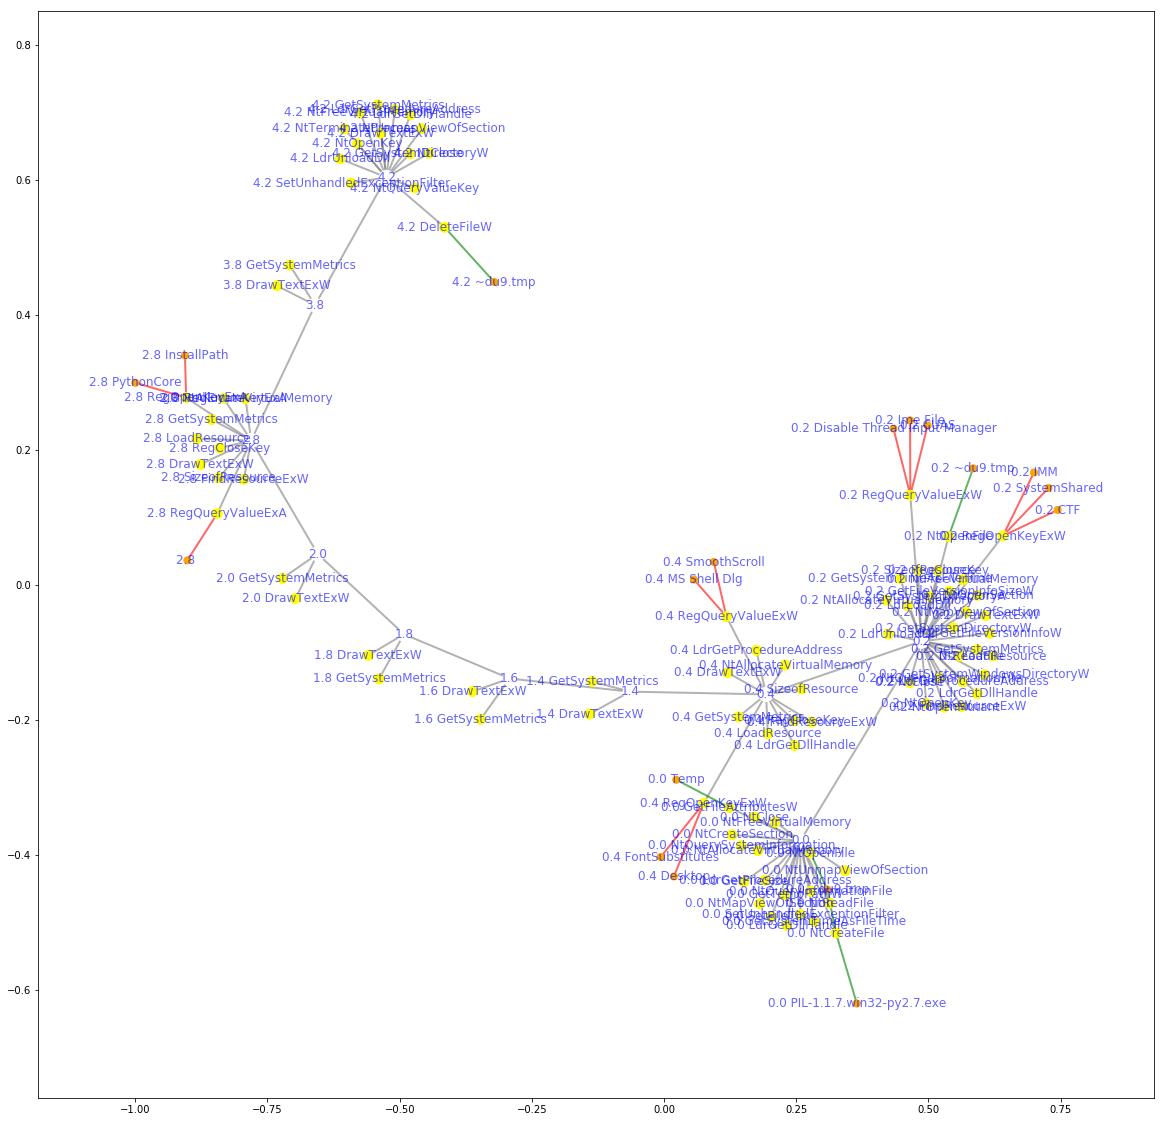

In [5]:
bin_start = int(rd[0]['time']//BIN)
for i in range(len(rd)):
    rd[i]['id'] = i
[t.update({'timed': round((int(t['time']//BIN)-bin_start)*BIN,2)}) for t in rd]
tl = sorted(list(set([round(int((t['time']//BIN)-bin_start)*BIN,2) for t in rd])))

G = nx.Graph()
rdf = [t for t in rd if t['api'] in APIFILTER] or rd
for i in range(len(tl)-1):
    if (not TIMERANGE[0] <= tl[i] <= TIMERANGE[1]) or (not TIMERANGE[0] <= tl[i+1] <= TIMERANGE[1]): continue
    G.add_edge(tl[i], tl[i+1], type='timed')
    G.node[tl[i]]['type']='timed'
    G.node[tl[i+1]]['type']='timed'
for t in rdf:
    if not TIMERANGE[0] <= t['timed'] <= TIMERANGE[1]: continue
    if 'all' in MODE or ('proc' in MODE and t['api'] == 'LdrGetProcedureAddress') or \
        ('file' in MODE and 'File' in t['api']) or ('reg' in MODE and 'Reg' in t['api']):
        api = str(t['timed'])+' '+t['api']
        G.add_edge(t['timed'], api, type='api')
        G.node[api]['type']='api'
    if ('proc' in MODE and t['api'] == 'LdrGetProcedureAddress'):
        additional = str(t['timed'])+' '+t['arguments']['function_name']
        G.add_edge(api, additional, type='proc')
        G.node[additional]['type']='additional'
    if ('file' in MODE and 'File' in t['api'] and 'filepath_r' in t['arguments']):
        additional = str(t['timed'])+' '+t['arguments']['filepath_r'].split('\\')[-1]
        G.add_edge(api, additional, type='file')
        G.node[additional]['type']='additional'
    if ('reg' in MODE and 'Reg' in t['api'] and 'regkey_r' in t['arguments']):
        additional = str(t['timed'])+' '+t['arguments']['regkey_r'].split('\\')[-1]
        G.add_edge(api, additional, type='reg')
        G.node[additional]['type']='additional'        
  
pos = nx.spring_layout(G)
plt.figure(figsize=(20,20))
nodecolor = ['white' if d['type']=='timed' else 'yellow' if d['type']=='api' else 'orange' for (v,d) in G.nodes(data=True)]
nodesize = [200 if d['type']=='timed' else 100 if d['type']=='api' else 50 for (v,d) in G.nodes(data=True)]
edgecolor = ['red' if d['type'] == 'reg' else 'green' if d['type'] == 'file' else 'gray' for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=nodesize, node_color=nodecolor, linewidths=1)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='b', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color=edgecolor, width=2)

白ノードの数字はプロセス生成からの経過時間  
黄色ノードは各時間ごとに呼び出されたAPI名  
オレンジノードは付加情報 (MODEによって表示が切り替えられる)
- LdrGetProcedureAddressで呼ばれた関数名
- APIが呼び出すファイル名（緑エッジ）
- APIが呼び出すレジストリキー（赤エッジ）